# Постановка задачи

## Стохастический градиентный спуск

При больших потоках данных возникает проблема их обработки. На помощь приходит улучшение классического градиентного спуска - _стохастический градиентный спуск_. Оно эффективно, когда в выборке много данных или требуется оценить большое количество параметров. В классической реализации градиентного спуска количество вычислений можно примерно оценить, как $(\text{# of gradients}) \cdot (\text{# of data points}) \cdot (\text{# of iterations})$

В стохастическом градиентном спуске на каждом шаге вместо, например, всего тренировочного датасета, берется одно значение. В этом случае можно оценить количество вычислений, как $(\text{# of gradients}) \cdot (\text{# of iterations})$

## Задача стохастической оптимизации

Пусть $\mathcal{X}$ - пространство параметров, случайная величина $\xi$ - случайное значение полученное из $\mathcal{X}$, $f(x, \xi)$ - функция потерь, $\mathcal{D}_i$ - распределение данных, $\xi_i$ - элемент выборки. Тогда задача будет выглядеть следующим образом:

$$f^* := \min_{x \in \mathbf{R}^d} \left[ f(x) := \mathbb{E}_{\xi\sim \mathcal{D}} [f(x, \xi)] \right]$$




На практике же, в качестве выборки используют не единственную точку, а некое подмножество точек (mini-batch).

Тогда шаг SGD выглядит следующим образом:

$$\text{Shuffle sample, randomly choose j, $n$ - batch size}$$

$$x_{k+1} = x_k - \gamma_k \nabla{F(x_k, \xi^{j:j+n})}$$

---

## Параллельные методы оптимизации

Помимо этого, еще одной идеей улучшения классического градиентного спуска - распределение вычислений между несколькими устройствами. Локально устройства запускают методы, затем спустя несколько итераций происходит общение между устройствами. Так, жизнь метода выглядит следующим образом: локально устройства вычисляют градиенты/оценки параметров, после некоторых итераций происходит передача сообщений (оценок параметров) между устройствами и так далее. В алгоритме ниже обмен сообщениями будет осуществляться через _gossip averaging_.

---

Объединяя данные две идеи, получаем метод Decentralized SGD. В работе уделяется внимание созданию обобщенного фреймворка для реализации Decentralized SGD на произвольных топологиях.

## Идея статьи

### Задача распределенной стохастической оптимизации

$$f^* := \min_{x \in \mathbf{R}^d} \left[ f(x) := \frac{1}{n} \sum_{i=1}^{n}f_i(x) \right]$$

где компоненты $f_i: \mathbb{R}^d \to \mathbb{R}$ распределены между $n$ вершинами и даны в стохастической форме:

$$f_i(x) := \mathbb{E}_{\xi_i \sim \mathcal{D}_i} F_i(x, \xi_i)$$

где $\mathcal{D}_i$ - распределение данных, $\xi_i$ - элемент выборки над пространством параметров $\mathcal{X}_i$ в вершине $i$.

Важным частным случаем этой задачи является стандартная минимизация эмпирического риска. В этом случае
$\mathcal{D}_i$ содержит конечное $m_i$ число элементов $\{\xi_i^1, \dots, \xi_i^{m_i} \}$. Тогда условия на компоненты можно переписать следующим образом:

$$f_i(x) = \frac{1}{m_i} \sum_{j=1}^{m_i} F_i(x, \xi_i^j)$$

Далее будем пользоваться следующими обозначениями:

<h5><center>$x_i^{(t)}$ - результат вычислений при вершине $i$ на $t$-ом шаге</center></h5>

$$\overline{x}^{(t)} := \frac{1}{n} \sum_{i=1}^{n} x_i^{(t)}$$

$$X^{(t)} := \left[x_1^{(t)}, \dots, x_n^{(t)}\right] \in \mathbb{R}^{d \times n}$$

$$\overline{X}^{(t)} := \left[ \overline{x}^{(t)}, \dots, \overline{x}^{(t)} \right] = X^{(t)}\frac{1}{n} \mathbf{1} \mathbf{1}^T$$

$$\partial{F(X^{(t)}, \xi^{(t)})} := \left[ \nabla{F_1(x_1^{(t)}, \xi_1^{(t)})}, \dots, \nabla{F_n(x_n^{(t)}, \xi_n^{(t)})} \right] \in \mathbb{R}^{d \times n}$$

### Gossip averaging


Рассмотрим граф сети, где вершины - устройства, а соединенные устройства имеют ребро между собой. Тогда обмен сообщениями реализуется усреднением слухов (_gossip averaging_). Его принцип имитирует процесс распространения сплетней (или же диффузии в природе). При общении, соседние узлы делятся своими локальными оценками, усредняя их со значениями, полученных от соседей (усреднение может быть взвешенное). Таким образом, устройства вычисляют приблизиженно централизованный результат.

Смешивающей матрицей (_mixing matrix_) называется симметричная, дважды стохастическая $(W \mathbf{1} = \mathbf{1} ,\, \mathbf{1}^T W = \mathbf{1})$ матрица $W \in [0, 1]^{n \times n}$

Более формально, _gossip averaging_ выглядит следующим образом:


$$x_i^{(t+1)} = \displaystyle \sum_{j=0}^n w_{ij}^{(t)}x_j^{(t)} \Leftrightarrow X^{(t+1)} = X^{(t)}W^{(t)},$$

т.е., $w_{ij} > 0 \Leftrightarrow$ устройства $i$ и $j$ являются соседями

Примеры топологий - звезда, кольцо, $2d$-тор, полный граф

Примеры весов:

1. (Одна степень вершин - True среднее) $w_{ij} = \frac{1}{deg_i + 1}$

2. (Разные степени вершин - Metropolis-Hastings) $w_{ij} = \frac{1}{\max(deg_i, deg_j) + 1}$

Однако не каждая смешивающая матрица подходит для нашей задачи. Нужно предположить, что смешивающая матрица действительно усредняет, т. е. спустя $\tau$ усредняющих шагов композиция матриц приближает значения матрицы $X$ к $\overline{X}.$

### Алгоритм Decentralized SGD

**Input:** $X^{(0)}$, размеры шагов $\{\gamma_i\}$, множество смешивающих матриц $W^{(t)} \sim \mathcal{W}^{(t)}$

**Step:**

$$X^{(t+\frac{1}{2})} := X^{(t)} - \gamma_t \partial{F(X^{(t)}, \xi^{(t)})}$$

$$X^{(t+1)} := X^{(t+\frac{1}{2})}W^{(t)}$$

**Output:** $\overline{x}^{(T)}$

---

## Общий фреймворк Decentralized SGD

Довольно понятно, что данный фрейморк является довольно обобщенным, потому что, до тех пор, пока объекты удовлетворяют предположениям, выбор протокола _gossip average_ произвольный, т. е. можно контролировать частоту обмена сообщениями, топологию сети устройств, веса средних. Так, данный фреймворк покрывает различные идеи реализации SGD:

1. _Centralized mini-batch SGD_ - устройства на собственных датасетах вычисляют градиенты, обмен градиентами происходит через сервер(или отдельную вершину), сервер отправляет полученный результат обратно устройствам. (Полный граф $W = \frac{1}{n} \mathbf{1} \mathbf{1}^T)$

2. _Loopless local SGD_ - на каждом шаге берется смешивающая матрица $W$ с вероятностью $\frac{1}{\tau}$ и $\mathbf{I}_n$ с вероятностью $1-\frac{1}{\tau}$ для некоторого параметра $\tau \geq 1$

3. _Local SGD_ - усреднение просиходит через каждые фиксированное $\tau$ шагов. В остальных шагах происходит только локальное вычисление. (Для таких $\tau - 1$ шагов берем смешивающую матрицу $W = \mathbf{I}_n$). Заметим, что при усреднении можно выбрать произвольную смешивающую матрицу, тогда мы получим _random decentralized local SGD_.

4. _Periodic decentralized SGD_ - множественные локальные вычисления и шаги усреднения (при некотором фиксированном $W$) повторяются периодически.

# Теоретические выкладки

## Предположения
Для работы алгоритма и следующих теоретических выкладок, нам могут пригодиться следующие предположения:

### $L$-гладкость $f$

1.1) $\forall i \in [n] \, F_i(X, \xi) : \mathbb{R}^d \times \Omega_i \to \mathbb{R}$ - дифференцируемая $\forall \xi \in supp(\mathcal{D_i})$, а также $\exists L \geq 0: \forall x, y \in \mathbb{R}^d, \xi \in supp(\mathcal{D}_i):$

$$\|\nabla{F_i(y, \xi)} - \nabla{F_i(x, \xi)} \| \leq L \| x - y \|$$

В некоторых случаях достаточно предположить $L$-гладкость функций $f_i$

1.2) $\forall i \in [n] \, f_i : \mathbb{R}^d \to \mathbb{R}$ - дифференцируема, а также $\exists L \geq 0 \, \forall x, y \in \mathbb{R}^d:$

$$\| \nabla{f_i(y)} - \nabla{f_i(x)} \| \leq L \| x - y \|$$

---

### $\mu$-выпуклость $f_i$

2) $\forall i \in [n] \, f_i: \mathbb{R}^d \to \mathbb{R}$ является $\mu$-выпуклой для $\mu \geq 0$. Другими словами, $\forall x, y \in \mathbb{R}^d:$

$$f_i(x) - f_i(y) + \frac{\mu}{2}\| x - y \|_2^2 \leq \langle \nabla{f_i(x)} ,\, x - y \rangle$$

---

### Ограниченность шума на оптимальном значении $x^*$
Чтобы выразить, насколько разнообразны функции $f_i$ в выпуклом случае достаточно измерить ее только в оптимальных точках (в строго выпуклых функциях такая точка обязательно найдется):

3.1) Пусть $\displaystyle x^* = \mathop{\arg\min}_{x \in \mathbb{R}^d} f_i(x)$, также определим:

$$\zeta_i^2 := \|\nabla{f_i(X^*)}\|_2^2, \qquad \overline{\zeta}^2 := \frac{1}{n} \sum_{i=1}^n \zeta_i^2$$

$$\sigma_i^2 := \mathbb{E}_{\xi_i} \| \nabla{F_i(x^*, \xi_i)} - \nabla{f_i(x^*)} \|_2^2, \qquad \overline{\sigma}^2 := \frac{1}{n} \sum_{i=1}^n \sigma_i^2$$

Предполагаем, что $\overline{\sigma}^2, \overline{\zeta}^2$ ограничены.

Здесь, $\overline{\sigma}^2$ - является показателем уровня шума, $\overline{\zeta}^2$ - разнообразия фукнций $f_i$.

Для невыпуклых задач необязательно существует единственная $x^*$, поэтому ослабим ограничение:

3.2) $\exists P, \hat{\zeta}$ такие, что $\forall x \in \mathbb{R}^d:$

$$\frac{1}{n} \sum_{i=1}^n \| \nabla{f_i(x)} \|_2^2 \leq \hat{\zeta}^2 + P \| \nabla{f(x)} \|_2^2.$$

Помимо этого, $\exists M, \hat{\sigma}$ такие, что $\forall x_1, \dots, x_n \in \mathbb{R}^d:$

$$\Psi \leq \hat{\sigma}^2 + \frac{M}{n} \sum_{i=1}^n \| \nabla{f(x_i)} \|_2^2,$$
где $\Psi := \frac{1}{n} \sum_{i=1}^n \mathbb{E}_{\xi_i} \| \nabla{F_i(x_i, \xi_i)} - \nabla{f_i(x_i)} \|_2^2.$

---

### Ожидаемая степень согласованности (о смешивающей матрице)

4) $\exists p \in (0, 1] ,\, \tau \geq 1$ такие, что $ \forall X \in \mathbb{R}^{d \times n} ,\, \forall l \in \{ 0, \dots, \frac{T}{\tau} \}:$

$$\mathbb{E}_W \| XW_{l, \tau} - \overline{X} \|_F^2 \leq (1-p) \| X - \overline{X} \|_F^2,$$

где $W_{l, \tau} = W^{((l+1)\tau - 1)} \dots W^{(l\tau)} ,\, \overline{X} := X \frac{\mathbf{1}\mathbf{1}^T}{n}$ и $\mathbb{E}$ берется над распределениями $W^{(t)} \sim \mathcal{W}^{(t)}$ с индексами $t \in \{ l\tau, \dots, (l+1)\tau - 1 \}.$

---

## Сходимость метода

Под этими предположениями мы можем сделать выводы о верхней и нижней границе числа итерации

### Верхняя граница, невыпуклый случай

Используя предположения 1.2, 3.2, ошибка $\displaystyle\frac{1}{T+1} \sum_{t=0}^T \mathbb{E} \| \nabla{f(\overline{x}^{(t)})} \|_2^2 \leq \varepsilon$ достигается итераций:

$$\mathcal{O} \left( \frac{\hat{\sigma}^2}{n\varepsilon^2} + \frac{\hat{\zeta}\tau\sqrt{M+1} + \hat{\sigma}\sqrt{p\tau}}{p\varepsilon^{3/2}} + \frac{\tau\sqrt{(P+1)(M+1)}}{p\varepsilon} \right) \cdot LF_0$$

### Верхняя граница, выпуклый случай

Используя предположения 1.1, 3.1, ошибка $\displaystyle \frac{1}{T+1} \sum_{t=0}^T(\mathbb{E}f(\overline{x}^{(t)}) - f^*) \leq \varepsilon$ достигается после итераций:

$$\mathcal{O} \left( \frac{\hat{\sigma}^2}{n\varepsilon^2} + \frac{\sqrt{L}(\overline{\zeta}\tau + \overline{\sigma}\sqrt{p\tau}}{p\varepsilon^{3/2}} + \frac{L\tau}{p\varepsilon} \right) \cdot R_0^2$$

### Верхняя граница, сильно выпуклый случай

Используя предположения 1.1, 3.1, 2, для $\mu \geq 0$ ошибка $\displaystyle \frac{1}{T+1} \sum_{t=0}^T \frac{w_t}{W_T}(\mathbb{E}f(\overline{x}^{(t)}) - f^*)  + \mu \mathbb{E} \| \overline{x}^{(T+1)} - x^* \|^2 \leq \varepsilon$ достигается после итераций:

$$\tilde{\mathcal{O}} \left( \frac{\overline{\sigma}^2}{\mu n\varepsilon^2} + \frac{\sqrt{L}(\overline{\zeta}\tau + \overline{\sigma}\sqrt{p\tau})}{\mu p\sqrt{\varepsilon}} + \frac{L\tau}{\mu p} \log{\frac{1}{\varepsilon}} \right),$$

для положительных $w_t ,\, F_0 := f(x_0) - f^* ,\, R_0 = \| x_0 - x^* \|$ обозначают изначальные ошибки

### Нижняя граница, сильно выпуклый случай

Пусть существеют сильно выпуклые и гладкие $f_i: \mathbb{R}^d \to \mathbb{R} ,\, i \in [n],$ с условием, что $L = \mu = 1$, без стохастического шума $(\overline{\sigma}^2 = 0)$ такие, что алгоритм для любой смешивающей матрицы $W^{(t)} \sim W$ при $p<1$  для $\tau=1$ требует как минимум

$$T = \tilde{\Omega} \left( \frac{\overline{\zeta}(1-p)}{\sqrt{\varepsilon}p} \right)$$

итерации для сходимости до точности $\varepsilon$

Можно показать, что условия, поставленные на $\overline{\zeta}$ являются необходимыми в сильно выпуклом случае и оценка не может быть улучшена

---

## Идея доказательств

### Верхняя оценка, сильно выпуклый случай

Лемма 1: С предположениями 1.1, 2, 3.1, 4 $\overline{x}^{(t)}$ в итерациях алгоритма с шагом $\eta_t \leq \frac{1}{12L}$ удовлетворяют:

$$\mathbb{E}_{\xi_1^{(t)}, \cdots, \xi_n^{(t)}} \| \overline{x}^{(t+1)} - x^* \|^2 \leq \left( 1-\frac{\eta_t \mu}{2} \right) \| \overline{x}^{(t)} - x^* \|^2 + \frac{\eta_t^2 \overline{\sigma}^2}{n} - \eta_t \left( f(\overline(x)^{(t)} - f^* \right) + \eta_t \frac{3L}{n} \sum_{i=1}^n \| \overline{x}^{(t)} - x_i^{(t)} \|^2$$

Лемма 2: C предположениями 1.1, 2, 3.1, 4, если $F_i$ являются выпуклыми и шаги $\eta_t \leq \frac{p}{96\sqrt{3} \tau L}, тогда:$

$$\Xi_t \leq \left(1 - \frac{p}{2} \right) \Xi_{m\tau} + \frac{p}{16\tau} \sum_{i=m\tau}^{t-1} \Xi_j + 36L \frac{\tau}{p} \sum_{j=m\tau}^{t-1} \eta_j^2 (f(\overline{x}^{(j)} - f(x^*)) + \left( \overline{\sigma}^2 + \frac{18\tau}{p} \overline{\zeta}^2 \right) \sum_{j=m\tau}^{t-1} \eta_j^2,$$

где $\Xi_t = \frac{1}{n} \mathbb{E}_t \sum_{i=1}^n \| x_i^{(t)} - \overline{x}^{(t)} \|^2$ - согласованное расстояние, $m = \lfloor \frac{t}{\tau} \rfloor - 1.$


### Нижняя оценка, сильно выпуклый случай

$$x^{(t+1)} = Wx^{(t+\frac{1}{2})} = W((1-\eta)x^{(t)} + \eta y)$$

In [1]:
import torch.multiprocessing as mp
import os
import matplotlib.pyplot as plt
from lib import *

In [2]:
world_size = 8
num_epochs = 1000
batch_size = 80
errors = mp.Queue()

errors_w = []
LRs = [1/2, 1/10, 1/100, 1/5.25, 1/5.25/12]
for lr in LRs:
    init_DSGD(errors, world_size, num_epochs, batch_size, W_centralized(world_size), lr=lr)
    errors_w.append(errors.get())

100%|██████████| 1000/1000 [05:15<00:00,  3.17it/s]

100%|██████████| 1000/1000 [04:28<00:00,  3.73it/s]

100%|██████████| 1000/1000 [04:28<00:00,  3.77it/s]

100%|██████████| 1000/1000 [04:28<00:00,  3.73it/s]

100%|██████████| 1000/1000 [04:28<00:00,  3.72it/s]


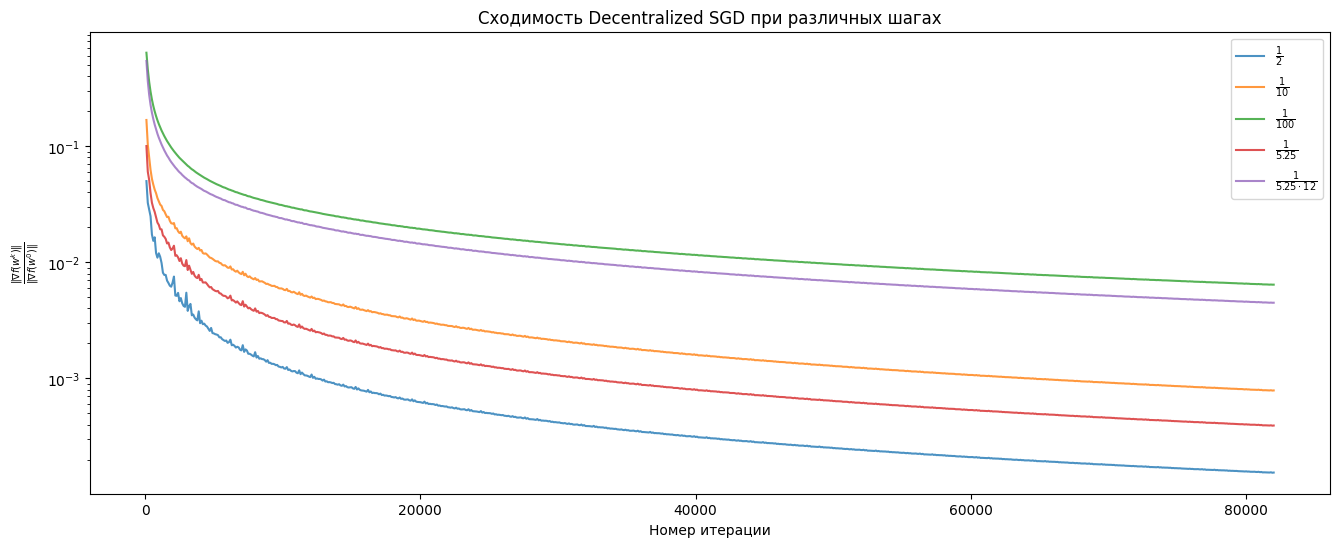

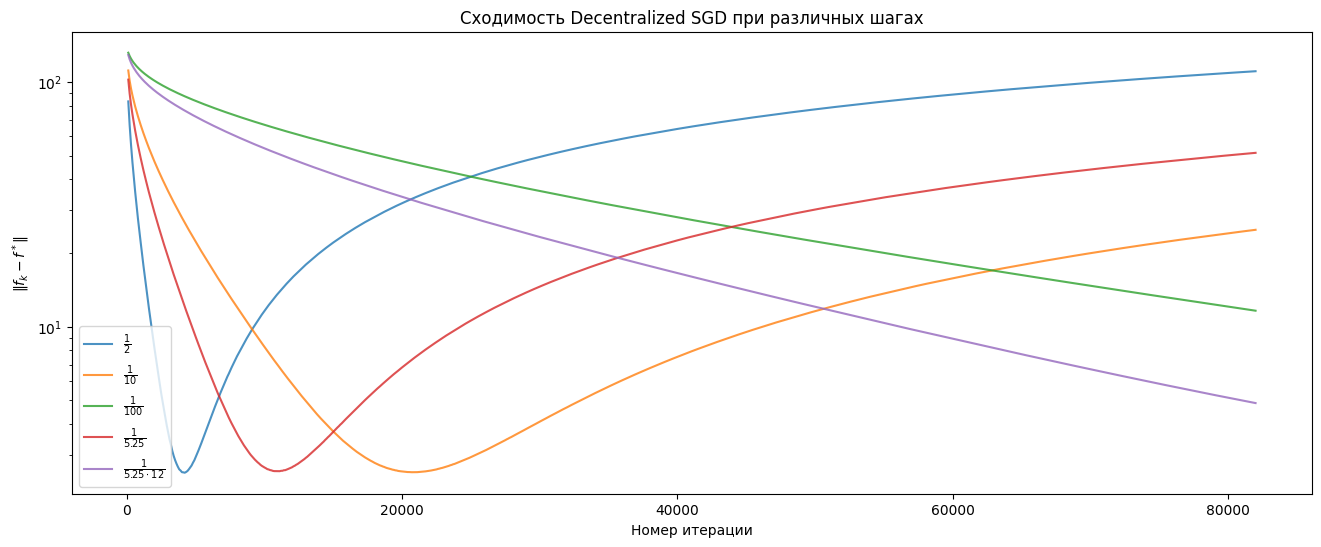

In [3]:
labels = [r'$\frac{1}{2}$', r'$\frac{1}{10}$', r'$\frac{1}{100}$', r'$\frac{1}{5.25}$', r'$\frac{1}{5.25 \cdot 12}$']
plt.figure(figsize=(16, 6))
for i in range(len(errors_w)):
    plt.plot(errors_w[i][0], errors_w[i][1], alpha=0.8, label=labels[i])
plt.title('Сходимость Decentralized SGD при различных шагах')
plt.ylabel(r'$\frac{\| \nabla{f(w^k)} \|}{\| \nabla{f(w^0)} \|}$')
plt.xlabel('Номер итерации')
plt.legend()
plt.yscale('log')
plt.figure(figsize=(16, 6))
for i in range(len(errors_w)):
    plt.plot(errors_w[i][0], errors_w[i][2], alpha=0.8, label=labels[i])
plt.title('Сходимость Decentralized SGD при различных шагах')
plt.ylabel(r'$\| f_k - f^* \|$')
plt.xlabel('Номер итерации')
plt.legend()
plt.yscale('log')

100%|██████████| 1000/1000 [14:48<00:00,  1.13it/s]

100%|██████████| 1000/1000 [14:48<00:00,  1.13it/s]

100%|██████████| 1000/1000 [05:21<00:00,  3.11it/s]

100%|██████████| 1000/1000 [05:21<00:00,  3.11it/s]

100%|██████████| 1000/1000 [05:21<00:00,  3.11it/s]


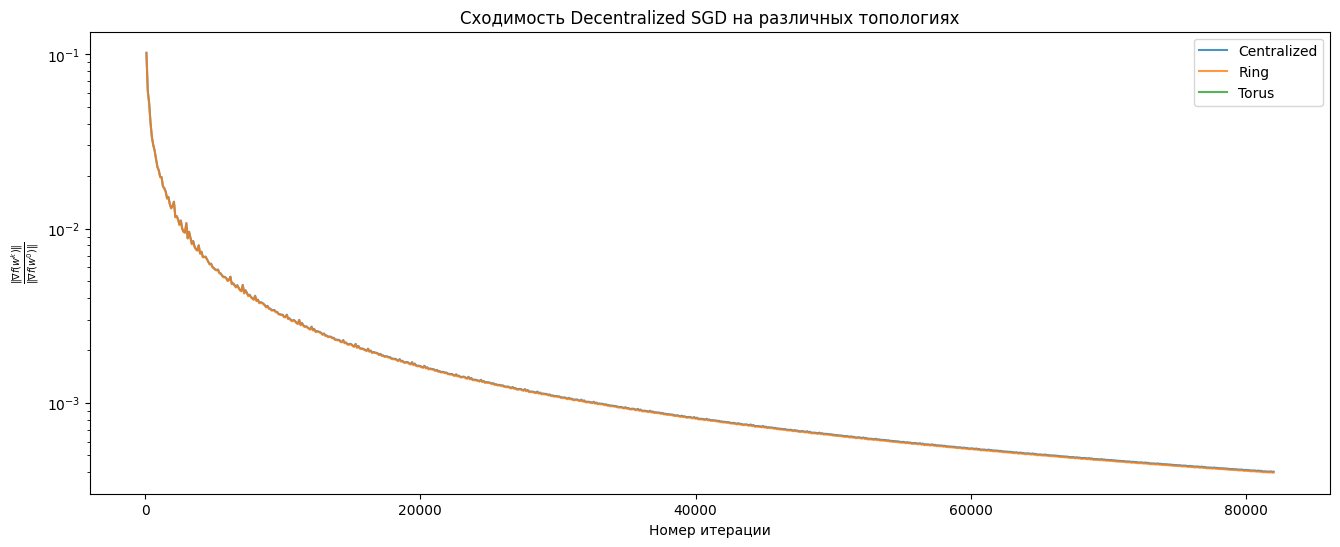

In [8]:
world_size = 8
num_epochs = 1000
batch_size = 80
errors = mp.Queue()

errors_w = []
Ws =[W_centralized(world_size), W_ring(world_size), W_torus(world_size)]
labels = ['Centralized', 'Ring', 'Torus']
for W in Ws:
    init_DSGD(errors, world_size, num_epochs, batch_size, W)
    errors_w.append(errors.get())

plt.figure(figsize=(16, 6))
for i in range(len(errors_w)):
    plt.plot(errors_w[i][0], errors_w[i][1], alpha=0.8, label=labels[i])
plt.title('Сходимость Decentralized SGD на различных топологиях')
plt.ylabel(r'$\frac{\| \nabla{f(w^k)} \|}{\| \nabla{f(w^0)} \|}$')
plt.xlabel('Номер итерации')
plt.legend()
plt.yscale('log')
plt.show()

100%|██████████| 100/100 [04:21<00:00,  2.61s/it]

100%|██████████| 100/100 [01:03<00:00,  1.57it/s]

100%|██████████| 100/100 [00:02<00:00, 39.17it/s]


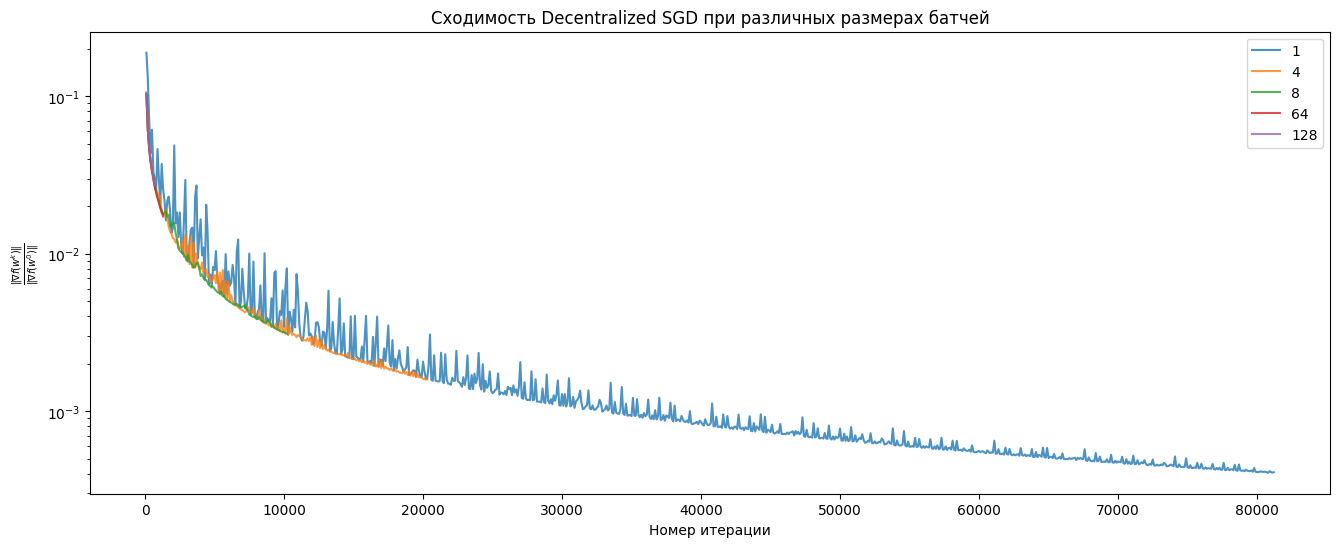

In [11]:
world_size = 8
num_epochs = 100
batch_size = 80
errors = mp.Queue()

errors_w = []
Ts = [1, 4, 8, 64, 128]
for T in Ts:
    init_DSGD(errors, world_size, num_epochs, T * world_size, W_centralized(world_size))
    errors_w.append(errors.get())
    
plt.figure(figsize=(16, 6))
for i in range(len(errors_w)):
    plt.plot(errors_w[i][0], errors_w[i][1], alpha=0.8, label=Ts[i])
plt.title('Сходимость Decentralized SGD при различных размерах батчей')
plt.ylabel(r'$\frac{\| \nabla{f(w^k)} \|}{\| \nabla{f(w^0)} \|}$')
plt.xlabel('Номер итерации')
plt.legend()
plt.yscale('log')
plt.show()

In [ ]:
world_size = 8
num_epochs = 1000
batch_size = 80
errors = mp.Queue()

errors_w = []
Ts = [1, 100, 1000, 10000]
Ws = []
for T in Ts:
    Ws.append(W_local(world_size, T, W_centralized(world_size)))

for W in Ws:
    init_DSGD(errors, world_size, num_epochs, batch_size, W)
    errors_w.append(errors.get())

plt.figure(figsize=(16, 6))
for i in range(len(errors_w)):
    plt.plot(errors_w[i][0], errors_w[i][1], alpha=0.8, label=Ts[i])
plt.title('Сходимость Local SGD на различных периодах')
plt.ylabel(r'$\frac{\| \nabla{f(w^k)} \|}{\| \nabla{f(w^0)} \|}$')
plt.xlabel('Номер итерации')
plt.legend()
plt.yscale('log')
plt.figure(figsize=(16, 6))
plt.show()

[W socket.cpp:464] [c10d] The server socket has failed to bind to [::]:29500 (errno: 48 - Address already in use).
[W socket.cpp:464] [c10d] The server socket has failed to bind to 0.0.0.0:29500 (errno: 48 - Address already in use).
[E socket.cpp:500] [c10d] The server socket has failed to listen on any local network address.
Process Process-15:
Process Process-16:
Process Process-11:
Process Process-14:
Process Process-17:
Process Process-12:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/Cellar/python@3.11/3.11.2/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/local/Cellar/python@3.11/3.11.2/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/local/Cellar/python@3.11/3.11.2/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multi

In [ ]:
world_size = 9
num_epochs = 100
batch_size = 90
errors = mp.Queue()

errors_w = []
Ws = [W_random(world_size), W_torus(world_size)]

for W in Ws:
    init_DSGD(errors, world_size, num_epochs, batch_size, W)
    errors_w.append(errors.get())

labels = ['Равномерная выборка из (Torus, Centralized, Ring)', 'Тор']
plt.figure(figsize=(16, 6))
for i in range(len(errors_w)):
    plt.plot(errors_w[i][0], errors_w[i][1], alpha=0.8, label=labels[i])
plt.title('Сходимость Local SGD на топологиях из распределения')
plt.ylabel(r'$\frac{\| \nabla{f(w^k)} \|}{\| \nabla{f(w^0)} \|}$')
plt.xlabel('Номер итерации')
plt.legend()
plt.yscale('log')
plt.figure(figsize=(16, 6))
plt.show()